This notebook creates a network of Greem Mountain Transit's Routes 1--11, using a geojson file downloaded from [transitland](https://www.transit.land/routes/r-drgv-2#export). This is a simple example of data STAT 6990 project.

* Author: Jean-Gabriel Young
* Email: <jyoung22@uvm.edu>
* License: MIT

# Helper function

In [1]:
import json
import os
import networkx as nx
import numpy as np

# Parsing

In [2]:

# Helper function to find stop_id by coordinates

def euclidean_distance(x, y):
    """Approximate the Euclidean distance between two points described by lat/long pairs."""
    mean_lat = np.radians((x[0] + y[0]) / 2.0)
    delta_lat = y[0] - x[0]
    delta_lon = y[1] - y[1]
    delta_lat_meters = delta_lat * 111000  # 1 degree of latitude is approximately 111 km
    delta_lon_meters = delta_lon * 111000 * np.cos(mean_lat)  # Adjust longitude distance by the cosine of the mean latitude
    return np.sqrt(delta_lat_meters**2 + delta_lon_meters**2)
    

def retrieve_closest_stop(coord, nodes):
    closest_distance = np.inf
    closest_stop_id = None
    for stop_id, info in nodes.items():
        # get euclidean distance between info['coordinates'] and 
        distance = euclidean_distance(info['coordinates'], coord)
        if distance < closest_distance:
            closest_distance = distance
            closest_stop_id = stop_id
    return closest_stop_id, closest_distance


def parse_route(transit_data, cutoff=20):
    """Function to extract nodes and edges from transitland GeoJSON route file.
    
    Notes
    -----
    We are not retrieving scheduling information even if available.
    """

    # populate node information
    meta = transit_data['features'][0]['properties']
    nodes = dict()
    route_info = {
        'route_long_name': meta['route_long_name'],
        'route_short_name': meta['route_short_name'],
        'route_url': meta['route_url'],
        'route_color': meta['route_color']
    }
    route_stops = meta['route_stops']
    
    for s in route_stops:
        stop_id = int(s['stop']['stop_id'])
        stop_name = s['stop']['stop_name']
        coordinates = np.array(s['stop']['geometry']['coordinates'])
        nodes[stop_id] = {'stop_name': stop_name, 'coordinates': coordinates}


    # populate edge information
    edges = []
    # there are multiple versions of the same route, we loop over them
    for points in data['features'][0]['geometry']['coordinates']:
        current_stop = None
        previous_stop = None
        # loop over the points for one version of the route    
        for p in points:
            closest_stop, distance = retrieve_closest_stop(p, nodes)
            if distance < cutoff:
                # some points are not stops, we ignore them
                if current_stop is None:
                    current_stop = closest_stop
                if current_stop is not None and current_stop != closest_stop:
                    previous_stop = current_stop
                    current_stop = closest_stop
                    edges.append((previous_stop, current_stop))
    return nodes, edges, route_info


In [3]:
nodes = dict()
edges = []
# loop over files in directory
for filename in os.listdir('data/'):
    with open(f'data/{filename}', 'r') as f:
        data = json.load(f)
    tmp_nodes, tmp_edges, info = parse_route(data, cutoff=10)
    print(f'Route {info["route_short_name"]} {info["route_long_name"]} has {len(tmp_nodes)} nodes and {len(tmp_edges)} edges.')
    edges += tmp_edges
    nodes.update(tmp_nodes)

Route 11 Airport has 68 nodes and 160 edges.
Route 2 Essex Junction has 77 nodes and 94 edges.
Route 3 Lakeside Commuter has 4 nodes and 2 edges.
Route 7 North Avenue has 70 nodes and 108 edges.
Route 10 Williston Essex Combo has 79 nodes and 92 edges.
Route 9 Winooski has 57 nodes and 81 edges.
Route 8 City Loop has 33 nodes and 77 edges.
Route 6 Shelburne Road has 93 nodes and 188 edges.
Route 1 Williston has 77 nodes and 154 edges.
Route 5 Pine Street has 33 nodes and 81 edges.


# Dumping the graph

First we validate the data rapidly:

In [4]:
g = nx.DiGraph()
g.add_nodes_from(nodes.keys())
g.add_edges_from(edges)
nx.set_node_attributes(g, {k: v['stop_name'] for k, v in nodes.items()}, 'name')
nx.set_node_attributes(g, {k: np.array(v['coordinates']) for k, v in nodes.items()}, 'pos')

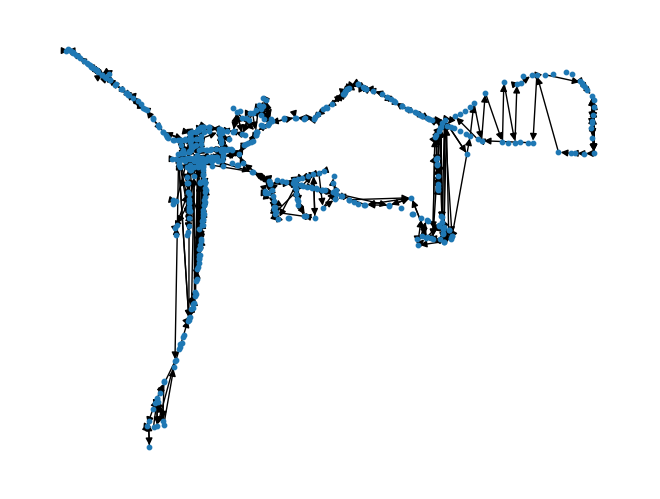

In [5]:
nx.draw(g, pos=nx.get_node_attributes(g, 'pos'), node_size=10, font_size=8)

We note that some transitions are imperfect. This is good enough for an example.

Then we reprocess the graphs with string attributes so that the GML data dump works.

In [6]:
g = nx.DiGraph()
g.add_nodes_from(nodes.keys())
g.add_edges_from(edges)
g.remove_nodes_from(list(nx.isolates(g)))
nx.set_node_attributes(g, {k: v['stop_name'] for k, v in nodes.items()}, 'name')
nx.set_node_attributes(g, {k: str(np.array(v['coordinates'])) for k, v in nodes.items()}, 'pos')

In [7]:
# write as GML
nx.write_gml(g, '../network.gml')

# 

# Prepare network card

Finally we prepare a data descriptor

In [8]:
import network_cards as nc

card = nc.NetworkCard(g)
print(card)

                   Name                     
                   Kind Directed, unweighted
              Nodes are                     
              Links are                     
         Considerations                     
        Number of nodes                  315
        Number of links                  536
--- Bidirectional links                  19%
      Degree (in/out)^1       1.70159 [0, 6]
             Degree^2^1      3.40317 [1, 10]
             Clustering               0.0813
              Connected     Weakly connected
 Assortativity (degree)               0.0442
          Node metadata                     
          Link metadata                     
       Date of creation                     
Data generating process                     
                 Ethics                     
                Funding                     
               Citation                     
                 Access                     

^1: Distributions summarized with average [min, max].


In [9]:
card.update_overall("Name", "Green Mountain Transit")
card.update_overall("Nodes are", "Bus stops")
card.update_overall("Links are", "Connections between stops")
card.update_overall("Considerations", "Stops are imputed based on GPS coordinates and may contain errors.")

card.update_metainfo({
    "Node metadata":           "Position (lat/long) and name of bus stop",
    "Link metadata":           "None",
    "Date of creation":        "2024-02-15",
    "Data generating process": "Route GEOJson files were downloaded from transit.land, a transit data aggregator, and processed with NetworkX.",
    "Funding":                 "None",
    "Citation":                "None",
    "Ethics":                  "n/a",
    'Access':                  "https://www.transit.land/operators/o-dru-greenmountaintransitagency (Accessed 2024-02-15)",
    })

Save as JSON

In [10]:
print(card)

                   Name                                                                                         Green Mountain Transit
                   Kind                                                                                           Directed, unweighted
              Nodes are                                                                                                      Bus stops
              Links are                                                                                      Connections between stops
         Considerations                                             Stops are imputed based on GPS coordinates and may contain errors.
        Number of nodes                                                                                                            315
        Number of links                                                                                                            536
--- Bidirectional links                                

In [11]:
# dump as nicely formatted JSON
with open('../network_card.json', 'w') as f:
    json.dump(card.to_dict(), f, indent=4)